In [75]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xg
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_excel('hourly-dataset_final.xlsx')

data.head()

,Date,Hour,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy,(Inverter)
0,2016-01-31,24,0.0,5.00,1.40,0.89,95.56,9.00,29.10,29.89,0.0,NaN
1,2016-02-01,1,0.0,7.88,1.16,0.62,91.04,7.04,29.11,29.90,0.0,NaN
2,2016-02-01,2,0.0,9.84,1.22,0.96,89.28,8.96,29.12,29.91,0.0,NaN
3,2016-02-01,3,0.0,9.84,1.02,0.61,89.12,6.36,29.14,29.93,0.0,NaN
4,2016-02-01,4,0.0,9.88,0.83,0.45,90.08,6.12,29.15,29.94,0.0,NaN


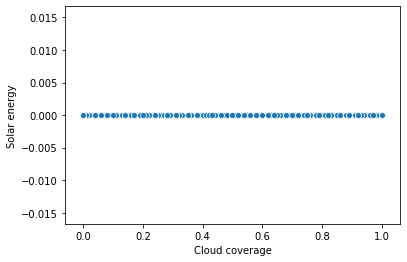

In [3]:
temp = data[data['Solar energy'] == 0]
sns.scatterplot(temp['Cloud coverage'], temp['Solar energy'])

In [4]:
data.drop(['Date', '(Inverter)'], axis=1, inplace=True)

## With night hours.

In [5]:
y = data['Solar energy']
x = data.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

xgb_r = xg.XGBRegressor(n_estimators = 14, seed = 123)

xgb_r.fit(train_X, train_y)

pred = xgb_r.predict(test_X)

rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))

mae = MAE(test_y, pred)
print("MAE : % f" %(mae))

r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

RMSE :  287533.218750
MAE :  288.125702
R2 :  0.847558


C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Night hours have a lot of influence over calculating MAE. This is the reson the value is soo less. Its not giving the correct idea about how well the day hours prediction is. Better to remove them and analyse.

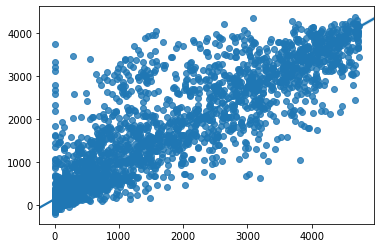

In [6]:
sns.regplot(test_y, pred)

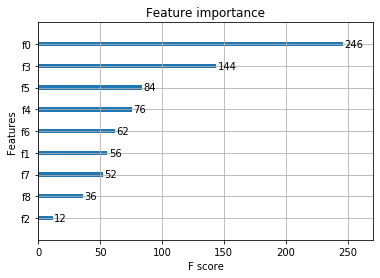

In [7]:
plot_importance(xgb_r)

In [8]:
data.head()

,Hour,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
0,24,0.0,5.00,1.40,0.89,95.56,9.00,29.10,29.89,0.0
1,1,0.0,7.88,1.16,0.62,91.04,7.04,29.11,29.90,0.0
2,2,0.0,9.84,1.22,0.96,89.28,8.96,29.12,29.91,0.0
3,3,0.0,9.84,1.02,0.61,89.12,6.36,29.14,29.93,0.0
4,4,0.0,9.88,0.83,0.45,90.08,6.12,29.15,29.94,0.0


## Without night hours.

In [14]:
temp = data[(data['Hour'] <= 18) & (data['Hour'] >=5)]

y = temp['Solar energy']
x = temp.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

xgb = xg.XGBRegressor(n_estimators = 800, seed = 123, eta=0.025, max_depth=8, subsample=0.75)
xgb.fit(train_X, train_y)
pred = xgb.predict(test_X)
mae = MAE(test_y, pred)
print("MAE : % f" %(mae))
rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

MAE :  409.912384
RMSE :  367372.750000
R2 :  0.836636


C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


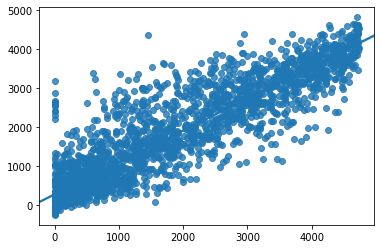

In [15]:
sns.regplot(test_y, pred)

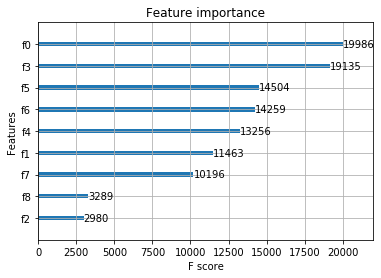

In [16]:
plot_importance(xgb)

In [18]:
pickle.dump(xgb, open('xgb MAE{} R2{}.pkl'.format(409.912384, 0.836636), 'wb'))

## LightGBM

In [20]:
import lightgbm as lgb

In [21]:
temp = data[(data['Hour'] <= 18) & (data['Hour'] >=5)]

y = temp['Solar energy']
x = temp.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

lgb_params = {
    'boosting_type': 'dart',
    'n_estimators': 2000,
    'learning_rate': 0.1,
    'num_leaves': 100,
    'subsample': 0.5,
    'random_state': 123,
    'n_jobs': -1
}

gbm = lgb.LGBMRegressor(**lgb_params)
gbm.fit(train_X, train_y)

pred = gbm.predict(test_X)

mae = MAE(test_y, pred)
print("MAE : % f" %(mae))

rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

MAE :  401.324971
RMSE :  377545.556096
R2 :  0.825761


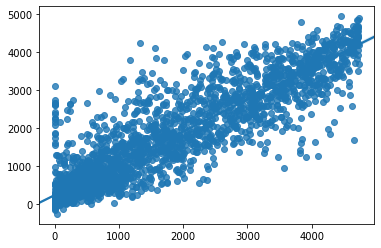

In [22]:
sns.regplot(test_y, pred)

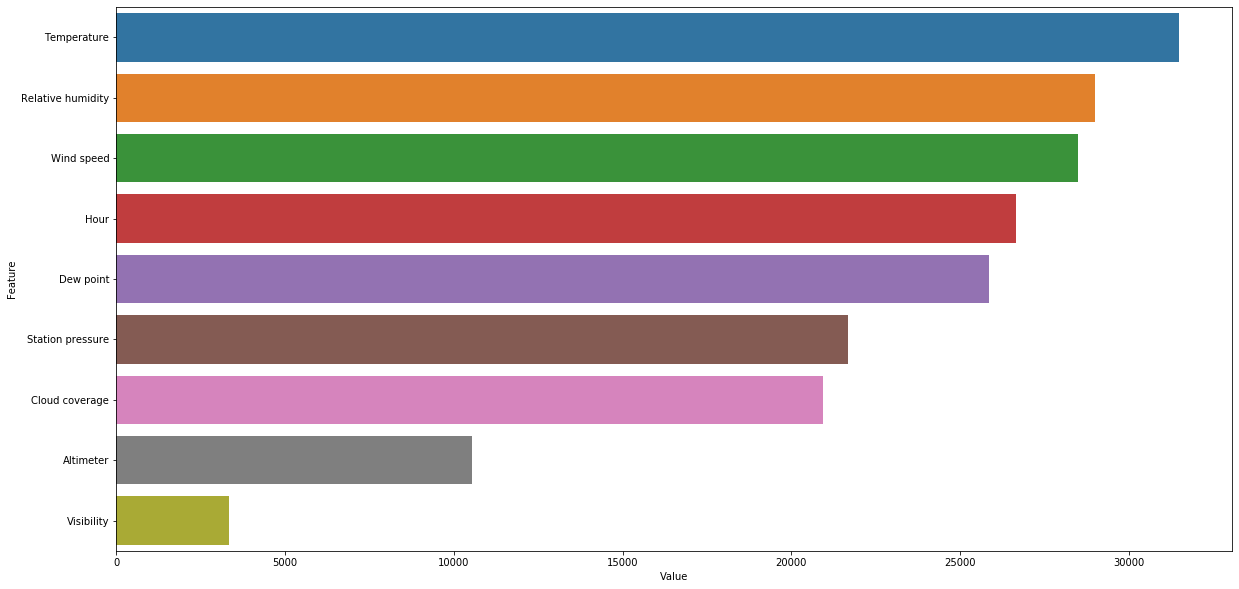

In [23]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,data.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

In [25]:
pickle.dump(gbm, open('lightGBM MAE{} R2{}.pkl'.format(401.324971, 0.825761), 'wb'))

## Random forest

In [26]:
temp = data[(data['Hour'] <= 18) & (data['Hour'] >=5)]

y = temp['Solar energy']
x = temp.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

n_e=[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_f=['auto','sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

random_grid = {'n_estimators': n_e,
               'max_features': max_f,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor()
rf_rcv=RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
rf_rcv.fit(train_X,train_y)
pred=rf_rcv.predict(test_X)

mae = MAE(test_y, pred)
print("MAE : % f" %(mae))

rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

In [27]:
params = rf_rcv.best_params_

In [28]:
rf = RandomForestRegressor(**params)

rf.fit(train_X,train_y)
pred=rf.predict(test_X)

mae = MAE(test_y, pred)
print("MAE : % f" %(mae))

rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

MAE :  434.973403
RMSE :  417144.589002
R2 :  0.815294


In [29]:
pickle.dump(rf, open('rf MAE{} R2{}.pkl'.format(434.973403, 0.815294), 'wb'))

## Gradient Boosting

In [30]:
temp = data[(data['Hour'] <= 18) & (data['Hour'] >=5)]

y = temp['Solar energy']
x = temp.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

gb = GradientBoostingRegressor()

learning_rate = [0.001, 0.01, 0.1, 0.2]
n_estimators=list(range(500,1000,100))
max_depth=list(range(4,9,4))
min_samples_split=list(range(4,9,2))
min_samples_leaf=[1,2,5,7]
max_features=['auto','sqrt']

param_grid = {"learning_rate":learning_rate,
              "n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

gb_rs = RandomizedSearchCV(estimator = gb, param_distributions = param_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

gb_rs.fit(train_X,train_y)

pred=gb_rs.predict(test_X)

mae = MAE(test_y, pred)
print("MAE : % f" %(mae))

rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=8, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=700; total time=   4.5s
[CV] END learning_rate=0.01, max_depth=8, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estima

In [31]:
gb_params = gb_rs.best_params_

In [38]:
gb = GradientBoostingRegressor(**gb_params)

gb.fit(train_X,train_y)

pred=gb.predict(test_X)

mae = MAE(test_y, pred)
print("MAE : % f" %(mae))

rmse = MSE(test_y, pred)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

MAE :  418.251194
RMSE :  389142.387802
R2 :  0.821742


In [39]:
pickle.dump(gb, open('gb MAE{} R2{}.pkl'.format(418.251194, 0.821742), 'wb'))

## Ensemble to Linear Regression

In [40]:
xgb = xg.XGBRegressor(n_estimators = 800, seed = 123, eta=0.025, max_depth=8, subsample=0.75)
gbm = lgb.LGBMRegressor(**lgb_params)
rf = RandomForestRegressor(**params)
gb = GradientBoostingRegressor(**gb_params)

In [44]:
base_models = [
    ('random_forest', rf),
    ('xgboost', xgb),
    ('light_gbm', gbm),
    ('gb', gb)
]

meta_model = LinearRegression()
stacking_model = StackingRegressor(
    estimators=base_models, 
    final_estimator=meta_model, 
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [45]:
temp = data[(data['Hour'] <= 18) & (data['Hour'] >=5)]

y = temp['Solar energy']
x = temp.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

In [46]:
stacking_model.fit(train_X, train_y)

StackingRegressor(cv=5,
                  estimators=[('random_forest',
                               RandomForestRegressor(max_depth=25,
                                                     max_features='sqrt',
                                                     n_estimators=1000)),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, eta=0.025,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None...
                                            validate_parameters=None,
                                    

In [47]:
stack_preds = stacking_model.predict(test_X)

C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


## Second try

In [48]:
mae = MAE(test_y, stack_preds)
print("MAE : % f" %(mae))

rmse = MSE(test_y, stack_preds)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, stack_preds)
print("R2 : % f" %(r2))

MAE :  402.282835
RMSE :  379184.145352
R2 :  0.833923


In [117]:
#FIRST TRY
# mae = MAE(test_y, stack_preds)
# print("MAE : % f" %(mae))

# rmse = MSE(test_y, stack_preds)
# print("RMSE : % f" %(rmse))

# r2 = r2_score(test_y, stack_preds)
# print("R2 : % f" %(r2))

MAE :  404.228479
RMSE :  368274.196102
R2 :  0.831950


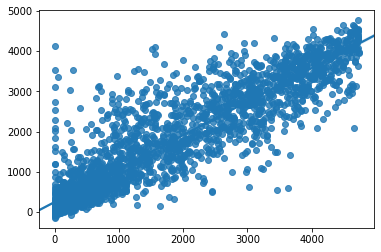

In [49]:
sns.regplot(test_y, stack_preds)

In [101]:
pickle.dump(stacking_model, open('stackLR MAE{} R2{}.pkl'.format(402.282835, 0.833923), 'wb'))

## Ensemble on NN

In [66]:
meta_model_nn = MLPRegressor(random_state=123, max_iter=500, learning_rate_init=0.01, verbose=True, early_stopping=True,
                         validation_fraction=0.15, hidden_layer_sizes=(4, 16, 1))
stacking_model_nn = StackingRegressor(
    estimators=base_models, 
    final_estimator=meta_model_nn, 
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [67]:
temp = data[(data['Hour'] <= 18) & (data['Hour'] >=5)]

y = temp['Solar energy']
x = temp.drop('Solar energy', axis=1)

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.30)

train_X = np.asarray(train_X).astype('float32')
test_X = np.asarray(test_X).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

In [68]:
stacking_model_nn.fit(train_X, train_y)

Iteration 1, loss = 1780844.55130540
Validation score: 0.760931
Iteration 2, loss = 267146.78313569
Validation score: 0.809222
Iteration 3, loss = 202718.24056214
Validation score: 0.808976
Iteration 4, loss = 198892.11182905
Validation score: 0.809840
Iteration 5, loss = 198407.60510484
Validation score: 0.810093
Iteration 6, loss = 199105.40623831
Validation score: 0.810040
Iteration 7, loss = 198876.17570894
Validation score: 0.809368
Iteration 8, loss = 198429.32548121
Validation score: 0.809722
Iteration 9, loss = 198964.12053601
Validation score: 0.808968
Iteration 10, loss = 199051.02575148
Validation score: 0.808659
Iteration 11, loss = 199675.85994113
Validation score: 0.809641
Iteration 12, loss = 199170.94713921
Validation score: 0.810155
Iteration 13, loss = 199425.75046765
Validation score: 0.809728
Iteration 14, loss = 198510.98905844
Validation score: 0.809876
Iteration 15, loss = 197974.34002938
Validation score: 0.809166
Iteration 16, loss = 198672.91631272
Validation 

StackingRegressor(cv=5,
                  estimators=[('random_forest',
                               RandomForestRegressor(max_depth=25,
                                                     max_features='sqrt',
                                                     n_estimators=1000)),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, eta=0.025,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None...
                                             random_state=123, subsample=0.5)),
                          

In [69]:
stack_preds_nn = stacking_model_nn.predict(test_X)

C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [70]:
mae = MAE(test_y, stack_preds_nn)
print("MAE : % f" %(mae))

rmse = MSE(test_y, stack_preds_nn)
print("RMSE : % f" %(rmse))

r2 = r2_score(test_y, stack_preds_nn)
print("R2 : % f" %(r2))

MAE :  396.994992
RMSE :  359110.873914
R2 :  0.844822


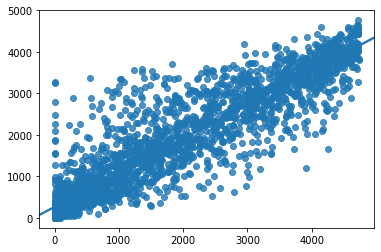

In [72]:
sns.regplot(test_y, stack_preds_nn)

In [90]:
pickle.dump(stacking_model_nn, open('stackNN MAE{} R2{}.pkl'.format(396.994992, 0.844822), 'wb'))

## Load the best model for predictions.

In [120]:
model = pickle.load(open('stackNN MAE{} R2{}.pkl'.format(396.994992, 0.844822), 'rb'))

In [121]:
arr = np.array([[24, 0.0, 5.00, 1.40, 0.89, 95.56, 9.00, 29.10, 29.89], 
                [10, 0.46, 10.00, 3.15, 1.07, 82.48, 2.12, 29.27, 30.06],
               [9, 0.92, 10.00, 1.97, 0.41, 86.12, 5.56, 29.24, 30.04],
               [8, 0.14, 9.92, 0.89, 0.30, 92.00, 2.76, 29.22, 30.01]])
arr

array([[24.  ,  0.  ,  5.  ,  1.4 ,  0.89, 95.56,  9.  , 29.1 , 29.89],
       [10.  ,  0.46, 10.  ,  3.15,  1.07, 82.48,  2.12, 29.27, 30.06],
       [ 9.  ,  0.92, 10.  ,  1.97,  0.41, 86.12,  5.56, 29.24, 30.04],
       [ 8.  ,  0.14,  9.92,  0.89,  0.3 , 92.  ,  2.76, 29.22, 30.01]])

In [122]:
list(model.predict(arr))

[51.939589506006065, 2007.1826729533618, 947.1631801127608, 614.846007331087]

In [113]:
model = pickle.load(open('xgb MAE409.912384 R20.836636.pkl', 'rb'))

In [114]:
list(model.predict(arr)) #-55.42495, 2372.4414, 898.0867, 622.4261

[-73.11984, 2101.5364, 866.0132, 717.49457]

In [108]:
data[data['Solar energy'] != 0].head()

,Hour,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
7,7,0.00,10.00,0.47,-0.04,90.08,6.00,29.20,29.99,84.29
8,8,0.14,9.92,0.89,0.30,92.00,2.76,29.22,30.01,531.00
9,9,0.92,10.00,1.97,0.41,86.12,5.56,29.24,30.04,923.75
10,10,0.46,10.00,3.15,1.07,82.48,2.12,29.27,30.06,1947.75
11,11,0.42,10.00,4.50,1.05,75.88,0.00,29.27,30.06,3562.00
